<a href="https://colab.research.google.com/github/BhuOne02/BdProject_TradeJoe/blob/main/demo11-conditional-gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional GANs

Based on the excellent tutorial [here](https://github.com/Yangyangii/GAN-Tutorial/blob/master/MNIST/Conditional-GAN.ipynb).

By formulating the process as a two-player game, Generative Adversarial Networks (GANs) can be very effective in generating realistic content. However, we may want to have more control over what is generated. Conditional GANs offer more control by letting us specify the *class* of output we want. Then we hand the generated content and the class it's supposed to be to the discriminator. The disciminator attempts to differentiate between the generated content of a certain class and the real content of a certain class.

The original paper that described conditional GANs is [here](https://arxiv.org/abs/1411.1784).

![](https://salu133445.github.io/dan/figs/cgan.png)


## Libaries

As always, we load lots of libraries.

In [1]:
import torch
from torchvision import datasets
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import os
from matplotlib.pyplot import imsave
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Data

For this demo, we will be using the FashionMNIST data set.

In [2]:
# A transform to convert the images to tensor and normalize their RGB values
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5], std=[0.5])]
)

data = datasets.FashionMNIST(root='../data/', train=True, transform=transform, download=True)

batch_size = 64
data_loader = DataLoader(dataset=data, batch_size=batch_size, shuffle=True, drop_last=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 191kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.54MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 16.0MB/s]


## Helper Functions

We'll need several helper functions for training the  GAN. The first converts labels to one hot encoded vectors, we will use it to pass the desired label to the generator. The second will plot a grid of 10x10 images from the generator.

In [3]:
def get_sample_image(G, DEVICE, n_noise=100):
    img = np.zeros([280, 280])  # A grid of 10x10 images (28 pixels each)
    for j in range(10):
        z = torch.randn(10, n_noise).to(DEVICE)  # Random noise for 10 samples
        y_hat = G(z).view(10, 28, 28)  # Generate images from noise
        result = y_hat.cpu().data.numpy()
        img[j*28:(j+1)*28] = np.concatenate([x for x in result], axis=-1)
    return img

## Architecture

We now instantiate the generator and discriminator architectures. The generator takes a random noise vector and a one hot encoded label as input and produces an image. The discriminator takes an image and a one hot encoded label as input and produces a single value between 0 and 1. The discriminator is trained to output 1 for real images and 0 for fake images. The generator is trained to fool the discriminator by outputting images that look real.

In [4]:
class Generator(nn.Module):
    def __init__(self, input_size=100, image_size=28*28):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, image_size),
            nn.Tanh()
        )
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        y_ = self.network(x)
        y_ = y_.view(x.size(0), 1, 28, 28)  # Reshape output to image format
        return y_


In [5]:
class Discriminator(nn.Module):
    def __init__(self, input_size=28*28, num_output=1):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_output),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        y_ = self.network(x)
        return y_

## Set up and Training

Now, we're ready to instantiate our models, hyperparameters, and optimizers. Since the task is for FashionMNIST, we will train for only 50 epochs. We will update the generator and discriminator in every step but often one can be trained more frequently than the other.

In [6]:
MODEL_NAME = 'StandardGAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
D = Discriminator().to(DEVICE) # randomly intialized
G = Generator().to(DEVICE) # randomly initialized
step = 0
n_noise = 100 # size of noise vector
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
all_ones = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator label: real
all_zeros = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label: fake


In [7]:
images, class_labels = next(iter(data_loader))
images = images.to(DEVICE)
print(images[:10].shape)


torch.Size([10, 1, 28, 28])


In [8]:
max_epoch = 50
if not os.path.exists('samples'):
    os.makedirs('samples')

for epoch in range(max_epoch):
    for idx, (images, _) in enumerate(data_loader):

        # Train Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, all_ones)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        fake_images = G(z)
        z_outputs = D(fake_images.detach())
        D_z_loss = criterion(z_outputs, all_zeros)

        D_loss = D_x_loss + D_z_loss
        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        # Train Generator
        z = torch.randn(batch_size, n_noise).to(DEVICE)
        fake_images = G(z)
        z_outputs = D(fake_images)
        G_loss = criterion(z_outputs, all_ones)

        G.zero_grad()
        G_loss.backward()
        G_opt.step()

        if step % 500 == 0:
            print(
                f"Epoch: {epoch+1}/{max_epoch}, Step: {step}, "
                f"D Loss: {D_loss.item():.4f}, G Loss: {G_loss.item():.4f}"
            )

        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, DEVICE, n_noise)
            imsave(f'samples/StandardGAN_step{str(step).zfill(3)}.jpg', img, cmap='gray')
            G.train()

        step += 1


Epoch: 1/50, Step: 0, D Loss: 1.3772, G Loss: 0.6805
Epoch: 1/50, Step: 500, D Loss: 1.1139, G Loss: 1.0414
Epoch: 2/50, Step: 1000, D Loss: 1.1422, G Loss: 1.0560
Epoch: 2/50, Step: 1500, D Loss: 1.1775, G Loss: 0.8771
Epoch: 3/50, Step: 2000, D Loss: 1.4178, G Loss: 0.9797
Epoch: 3/50, Step: 2500, D Loss: 1.3031, G Loss: 0.8046
Epoch: 4/50, Step: 3000, D Loss: 1.3041, G Loss: 0.6928
Epoch: 4/50, Step: 3500, D Loss: 1.2959, G Loss: 0.8518
Epoch: 5/50, Step: 4000, D Loss: 1.3933, G Loss: 0.9006
Epoch: 5/50, Step: 4500, D Loss: 1.3315, G Loss: 0.8272
Epoch: 6/50, Step: 5000, D Loss: 1.3076, G Loss: 1.0679
Epoch: 6/50, Step: 5500, D Loss: 1.3581, G Loss: 0.7467
Epoch: 7/50, Step: 6000, D Loss: 1.3365, G Loss: 0.9165
Epoch: 7/50, Step: 6500, D Loss: 1.2583, G Loss: 0.7865
Epoch: 8/50, Step: 7000, D Loss: 1.3437, G Loss: 0.7388
Epoch: 9/50, Step: 7500, D Loss: 1.4003, G Loss: 0.7480
Epoch: 9/50, Step: 8000, D Loss: 1.3409, G Loss: 0.7247
Epoch: 10/50, Step: 8500, D Loss: 1.3612, G Loss: 0.

Now let's plot these images. At first, the generator just produces noise (as we expect).

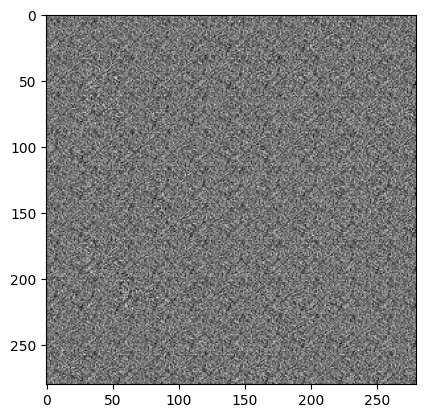

In [9]:
img = mpimg.imread('samples/StandardGAN_step000.jpg')
imgplot = plt.imshow(img)
plt.show()

But then it gets better.

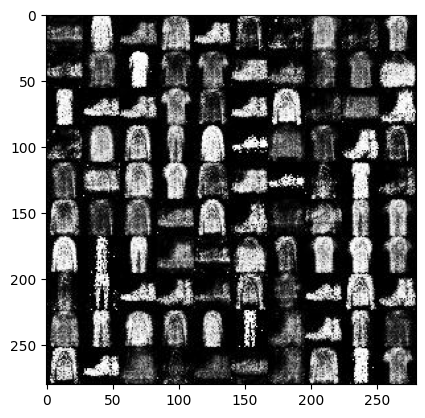

In [10]:
img = mpimg.imread('samples/StandardGAN_step5000.jpg')
imgplot = plt.imshow(img)
plt.show()

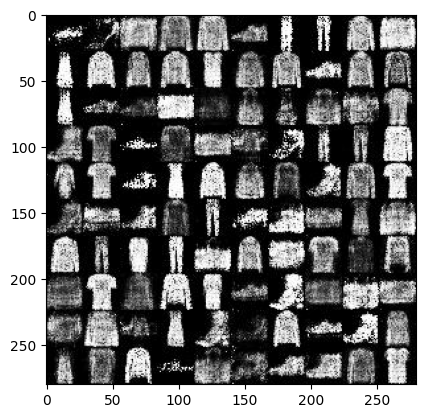

In [11]:
img = mpimg.imread('samples/StandardGAN_step9000.jpg')
imgplot = plt.imshow(img)
plt.show()

# Measures of GAN Quality

1.Inception Score (IS)

Definition:
The Inception Score measures both the quality and diversity of generated images. It evaluates how confidently a pretrained classifier (such as InceptionV3) assigns class labels to the generated samples.

Explanation:

If the classifier gives a confident, sharp prediction for each generated image, it suggests the image looks realistic.

If the predictions for all generated images are spread across many classes, it means the generator is producing a diverse set of samples instead of repeating the same pattern.

Thus, high-quality and varied images lead to a high Inception Score, while blurry or repetitive images lead to a low score.

Interpretation:

High IS → The generated images are sharp, realistic, and diverse.

Low IS → Images are blurry, hard to classify, or lack diversity (mode collapse).

2.Fréchet Inception Distance (FID): FID measures how close the generated images are to the real dataset in terms of both:


*   Overall appearance
*   Feature statistics learned by a neural network

Instead of using raw pixels, it compares deep features extracted by a pretrained model, making it a much more reliable metric.

FID compares:


*   The “average” feature representation of real images
*   The “average” representation of generated images
*   And how spread-out (diverse) they are


If your generated images look realistic and diverse, the two distributions will be similar.

Interpretation:

Lower FID = Generated images look close to real images


Higher FID = Generated images look unrealistic or inconsistent


In [12]:
import torch
import torch.nn.functional as F
from torchvision.models import inception_v3
from torchvision.transforms import Resize, Normalize, ToTensor, Compose

inception = inception_v3(pretrained=True, transform_input=False).eval().to(DEVICE)
transform = Compose([
    Resize((299, 299)),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 133MB/s]


In [13]:
def preprocess_images(images):
    """Resize and normalize images for InceptionV3."""
    if len(images.shape) == 4 and images.shape[1] == 1:
        images = images.repeat(1, 3, 1, 1)
    images = transform(images / 2.0 + 0.5)
    return images

In [14]:
def calculate_inception_score(generator, num_images=5000, batch_size=64, splits=10):
    generator.eval()
    all_preds = []
    with torch.no_grad():
        for _ in range(num_images // batch_size):
            z = torch.randn(batch_size, 100).to(DEVICE)
            fake_images = generator(z)
            fake_images = preprocess_images(fake_images)
            preds = inception(fake_images).softmax(dim=1)
            all_preds.append(preds)

    all_preds = torch.cat(all_preds, dim=0)

    split_scores = []
    for k in range(splits):
        part = all_preds[k * (all_preds.size(0) // splits): (k + 1) * (all_preds.size(0) // splits)]
        p_yx = part.mean(dim=0)
        p_y = all_preds.mean(dim=0)
        kl_div = p_yx * (torch.log(p_yx + 1e-10) - torch.log(p_y + 1e-10))
        split_scores.append(torch.exp(kl_div.sum()))

    mean_is = torch.mean(torch.tensor(split_scores)).item()
    std_is = torch.std(torch.tensor(split_scores)).item()
    return mean_is, std_is

mean_is, std_is = calculate_inception_score(G, num_images=5000, batch_size=64, splits=10)
print(f"Inception Score: {mean_is} ± {std_is}")

Inception Score: 1.0090056657791138 ± 0.0012717886129394174


In [15]:
import torch
import numpy as np
from torchvision.models import inception_v3
from torchvision.transforms import Resize, Normalize, ToTensor, Compose
from scipy.linalg import sqrtm

inception = inception_v3(pretrained=True, transform_input=False).eval().to(DEVICE)
transform = Compose([
    Resize((299, 299)),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
def extract_features(images, model, batch_size=64):
    features = []
    with torch.no_grad():
        for batch in torch.split(images, batch_size):
            batch = preprocess_images(batch).to(DEVICE)
            batch_features = model(batch).detach().cpu().numpy()
            features.append(batch_features)
    return np.concatenate(features, axis=0)


In [17]:
def calculate_fid(real_images, fake_images):
    real_features = extract_features(real_images, inception)
    fake_features = extract_features(fake_images, inception)

    mu_real, sigma_real = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu_fake, sigma_fake = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)

    diff = mu_real - mu_fake
    covmean = sqrtm(sigma_real.dot(sigma_fake))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma_real + sigma_fake - 2 * covmean)
    return fid

In [18]:
real_images, _ = next(iter(data_loader))
real_images = real_images.to(DEVICE)
G.eval()
with torch.no_grad():
    z = torch.randn(batch_size, 100).to(DEVICE)
    fake_images = G(z)

fid_score = calculate_fid(real_images, fake_images)
print(f"FID Score: {fid_score}")

FID Score: 918.0173692722849


# Conclusion about metrics

The metrics for your FashionMNIST GAN—an FID score of **918.0** and an Inception Score of **1.009 ± 0.0013**—similarly indicate that the generated images lack both quality and diversity. The very high FID reflects a large discrepancy between the real and generated image distributions, while the low IS suggests that the samples are neither sharp nor semantically diverse, and may even exhibit mild mode collapse. These results highlight how challenging it is for the current GAN setup to capture the complex structure and variability of FashionMNIST. Overall, while the model is producing somewhat structured outputs, there remains substantial room for improvement through extended training, more expressive architectures (e.g., convolutional GANs or conditional GANs), and careful hyperparameter tuning.


# Comment on Image Quality

The images generated by the MNIST Conditional GAN are relatively clear and structured, showing distinct shapes that resemble handwritten digits from 0 to 9. Because the model is conditioned on class labels, the generator can focus on producing specific patterns for each digit. Although there is some noise and a few artifacts, the outputs are still recognizable as numbers, indicating that the generator successfully captures the simpler patterns present in the MNIST dataset. This is expected, since MNIST consists of low-complexity, highly regular shapes with limited variation compared to FashionMNIST.

In contrast, the images produced by the FashionMNIST GAN lack clarity and definition. The generated samples appear noisy and blurry, making it difficult to identify specific clothing items such as shirts, shoes, or dresses. This suggests that the GAN struggles to learn the more complex and diverse visual patterns in FashionMNIST, likely due to the absence of label conditioning and the limitations of the current training setup. The higher complexity of FashionMNIST compared to MNIST underscores the challenge of using a standard GAN for this dataset and highlights the need for improved architectures, longer training, or additional techniques to better model its rich structure.
